In [2]:
import numpy as np
import cudaq
from typing import List
from matplotlib import pyplot as plt

# Grover's Algorithm

# Quantum States in Hilbert Space

Let $\Sigma = \{0,1\}$, and $N = 2^n$.

Consider a single qubit system with Hilbert space:
$$
\mathcal{H} \cong \mathbb{C}^2
$$
A general quantum state is:
$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle \in \mathcal{H}, \quad \text{where } \alpha, \beta \in \mathbb{C} \text{ and } |\alpha|^2 + |\beta|^2 = 1
$$

For a system of $n$ qubits, the Hilbert space is the $n$-fold tensor product:
$$
\mathcal{H}^{\otimes n} = \underbrace{\mathcal{H} \otimes \mathcal{H} \otimes \cdots \otimes \mathcal{H}}_{n \text{ times}} \cong \mathbb{C}^{N}
$$
A general $n$-qubit state is:
$$
|\psi\rangle = \sum_{x \in \{0,1\}^n} \alpha_x |x\rangle \in \mathcal{H}^{\otimes n}, \quad \text{where } \sum_x |\alpha_x|^2 = 1
$$

# Multi-Qubit State Representation



---

Let $|u\rangle \in \mathcal{H}^{\otimes n}$ be the uniform superposition state:
$$
|u\rangle = \frac{1}{\sqrt{N}} \sum_{x \in \Sigma^n} |x\rangle
$$

With the Hadamard gate $H \in \mathcal{C}^{2 \times 2}$
$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}
$$

with action on basis states:
$$
H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle), \quad
H|1\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
$$

$|u\rangle$ can be prepared from $|0\rangle^{\otimes n}$ by applying $H$ to each qubit:
$$
|u\rangle = H^{\otimes n} |0\rangle^{\otimes n}
$$

---

Moreover, $X$, $Y$, $Z$ defined as:
$$
X = \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}, \quad
Y = \begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}, \quad
Z = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}
$$

For controlled gates $C\textcolor{green}{U}$ where $\textcolor{green}{U}$ is a single qubit gate (e.g. $CX$, $CZ$) with the first qubit as control and the second as target:
$$
C\textcolor{green}{U}(|0\rangle \otimes |x\rangle) = |0\rangle \otimes |x\rangle
$$
$$
C\textcolor{green}{U}(|1\rangle \otimes |x\rangle) = |1\rangle \otimes \textcolor{green}{U}|x\rangle
$$

---

e.g. for $CX$:
$$CX|00\rangle = |00\rangle, \quad CX|01\rangle = |01\rangle, \quad CX|10\rangle = |11\rangle, \quad CX|11\rangle = |10\rangle$$
and can be represented as:
$$CX = \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{pmatrix}$$

---

for $CZ$:
$$CZ|00\rangle = |00\rangle, \quad CZ|01\rangle = |01\rangle, \quad CZ|10\rangle = |10\rangle, \quad CZ|11\rangle = -|11\rangle$$
and can be represented as:
$$CZ = \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1\end{pmatrix}$$

In [9]:
@cudaq.kernel
def kernel_control():
    v = cudaq.qvector(4)
    h(v)
    x.ctrl([v[0], v[2]], v[1])
print(cudaq.draw(kernel_control))

     ╭───╮     
q0 : ┤ h ├──●──
     ├───┤╭─┴─╮
q1 : ┤ h ├┤ x ├
     ├───┤╰─┬─╯
q2 : ┤ h ├──●──
     ├───┤     
q3 : ┤ h ├─────
     ╰───╯     



In [18]:
@cudaq.kernel
def kernel_H(v: cudaq.qvector):
    h(v)

@cudaq.kernel
def kernel_example_H(qb: int):
    v = cudaq.qvector(qb)
    kernel_H(v)

In [20]:
qb = 3
results = cudaq.sample(kernel_example_H, qb, shots_count=10000)
print(results)
state = cudaq.get_state(kernel_example_H, qb)
print(state)
print(1/np.sqrt(1<<qb))
print(cudaq.draw(kernel_example_H, qb))

{ 000:1218 001:1257 010:1283 011:1249 100:1265 101:1263 110:1194 111:1271 }

SV: [(0.353553,0), (0.353553,0), (0.353553,0), (0.353553,0), (0.353553,0), (0.353553,0), (0.353553,0), (0.353553,0)]

0.35355339059327373
     ╭───╮
q0 : ┤ h ├
     ├───┤
q1 : ┤ h ├
     ├───┤
q2 : ┤ h ├
     ╰───╯



# Oracle Part

Let $f: \{0,1\}^n \to \{0,1\}$ be a function defined as

$$
f(x) = \begin{cases}
1 & \text{if } x \text{ is a solution} \\
0 & \text{otherwise}
\end{cases}
$$

We can define an Unitary operator $U_f$ that acts on basis states as follows:
$$
U_f |x\rangle|a\rangle = |x\rangle|a \oplus f(x)\rangle
$$

In [23]:
@cudaq.kernel
def kernel_picknum_mark(qb: int, l: List[int]):
    v = cudaq.qvector(qb)
    r = cudaq.qubit()
    kernel_H(v)
    for k in l:
        for i in range(qb):
            if int(k / (2 ** i)) % 2 == 0:
                x(v[qb - i - 1])
        x.ctrl([v], r)
        for i in range(qb):
            if int(k / (2 ** i)) % 2 == 0:
                x(v[qb - i - 1])


In [24]:
qb, nums = 4, [3, 6]
results = cudaq.sample(kernel_picknum_mark, qb, nums, shots_count=1000)
print(results)
state = cudaq.get_state(kernel_picknum_mark, qb, nums)
print(state)
print(cudaq.draw(kernel_picknum_mark, qb, nums))

{ 00000:69 00010:59 00100:45 00111:72 01000:60 01010:59 01101:60 01110:64 10000:66 10010:62 10100:63 10110:77 11000:59 11010:52 11100:62 11110:71 }

SV: [(0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0,0), (0.25,0), (0.25,0), (0.25,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0.25,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0.25,0), (0,0), (0,0), (0,0)]

     ╭───╮╭───╮     ╭───╮╭───╮     ╭───╮
q0 : ┤ h ├┤ x ├──●──┤ x ├┤ x ├──●──┤ x ├
     ├───┤├───┤  │  ├───┤╰───╯  │  ╰───╯
q1 : ┤ h ├┤ x ├──●──┤ x ├───────●───────
     ├───┤╰───╯  │  ╰───╯       │       
q2 : ┤ h ├───────●──────────────●───────
     ├───┤       │  ╭───╮       │  ╭───╮
q3 : ┤ h ├───────●──┤ x ├───────●──┤ x ├
     ╰───╯     ╭─┴─╮╰───╯     ╭─┴─╮╰───╯
q4 : ──────────┤ x ├──────────┤ x ├─────
               ╰───╯          ╰───╯     



Let $Z_f$ be 

In [52]:
@cudaq.kernel
def kernel_picknum_flip(v: cudaq.qvector, l: List[int]):
    qb = len(v)
    for k in l:
        for i in range(qb):
            if int(k / (2 ** i)) % 2 == 0:
                x(v[qb - i - 1])
        z.ctrl([v[0:qb-1]], v[qb-1])
        for i in range(qb):
            if int(k / (2 ** i)) % 2 == 0:
                x(v[qb - i - 1])


@cudaq.kernel
def kernel_oracle_example(qb: int, l: List[int]):
    v = cudaq.qvector(qb)
    h(v)
    kernel_picknum_flip(v, l)

In [53]:
qb, nums = 4, [3, 6]
results = cudaq.sample(kernel_oracle_example, qb, nums, shots_count=1000)
print(results)
state = cudaq.get_state(kernel_oracle_example, qb, nums)
print(state)
print(cudaq.draw(kernel_oracle_example, qb, nums))

{ 0000:67 0001:66 0010:56 0011:46 0100:71 0101:64 0110:60 0111:63 1000:59 1001:60 1010:63 1011:52 1100:63 1101:71 1110:72 1111:67 }

SV: [(0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (-0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (0.25,0), (-0.25,0), (0.25,0), (0.25,0), (0.25,0)]

     ╭───╮╭───╮     ╭───╮╭───╮     ╭───╮
q0 : ┤ h ├┤ x ├──●──┤ x ├┤ x ├──●──┤ x ├
     ├───┤├───┤  │  ├───┤╰───╯  │  ╰───╯
q1 : ┤ h ├┤ x ├──●──┤ x ├───────●───────
     ├───┤╰───╯  │  ╰───╯       │       
q2 : ┤ h ├───────●──────────────●───────
     ├───┤     ╭─┴─╮╭───╮     ╭─┴─╮╭───╮
q3 : ┤ h ├─────┤ z ├┤ x ├─────┤ z ├┤ x ├
     ╰───╯     ╰───╯╰───╯     ╰───╯╰───╯



### Diffusion Part

In [56]:
@cudaq.kernel
def kernel_diffuser(v: cudaq.qvector):
    qb = len(v)
    h(v)
    x(v)
    z.ctrl([v[0:qb-1]], v[qb-1])
    x(v)
    h(v)

@cudaq.kernel
def kernel_diffuser_example(qb: int):
    v = cudaq.qvector(qb)
    kernel_diffuser(v)

In [57]:
print(cudaq.draw(kernel_diffuser_example, 4))

     ╭───╮╭───╮     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤├───┤  │  ├───┤├───┤
q1 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤├───┤  │  ├───┤├───┤
q2 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤├───┤╭─┴─╮├───┤├───┤
q3 : ┤ h ├┤ x ├┤ z ├┤ x ├┤ h ├
     ╰───╯╰───╯╰───╯╰───╯╰───╯



### Grover's Algorithm Implementation

In [60]:
@cudaq.kernel
def kernel_grover(qb:int, l: List[int], iterations: int):
    v = cudaq.qvector(qb)
    h(v)
    for _ in range(iterations):
        kernel_picknum_flip(v, l)
        kernel_diffuser(v)
    # cudaq.mz(v)

In [164]:
# qb = 5
# nums = [3, 12, 5]

qb = 7
nums = [68, 103, 119, 45]

zeta = np.arcsin(np.sqrt(len(nums) / 2**qb))
print(f'zeta: {zeta / np.pi * 180:.2f}')

iters = round((np.pi / (4 * zeta)) - 0.5)
print(f'\nOptimal iterations: {iters}')
optimal_zeta = zeta * (2 * iters + 1)
print(f'Optimal zeta: {optimal_zeta / np.pi * 180:.2f}')

probs_true = np.abs(np.sin(optimal_zeta))**2
probs_false = np.abs(np.cos(optimal_zeta))**2
print(f'\nProbability of True: {probs_true:.4f}')
print(f'Probability of False: {probs_false:.4f}')

zeta: 10.18

Optimal iterations: 4
Optimal zeta: 91.64

Probability of True: 0.9992
Probability of False: 0.0008


In [180]:
shots = 10000
results = cudaq.sample(kernel_grover, qb, nums, iters, shots_count=shots)
# print(results)

result_final = np.zeros(2**qb)
probs = np.zeros_like(result_final)
pt = 0
for i in results:
    result_final[int(i, 2)] = results[i]
    probs[int(i, 2)] = results[i] / shots
    if int(i, 2) in nums:
        pt += probs[int(i, 2)]
# print(probs)
print(f'Probability of measuring True: {pt:.5f}')
print(f'Probability of Theoretical True: {probs_true:.5f}')

print(f'\nProbability of measuring False: {1-pt:.5f}')
print(f'Probability of Theoretical False: {probs_false:.5f}')

Probability of measuring True: 0.99910
Probability of Theoretical True: 0.99918

Probability of measuring False: 0.00090
Probability of Theoretical False: 0.00082


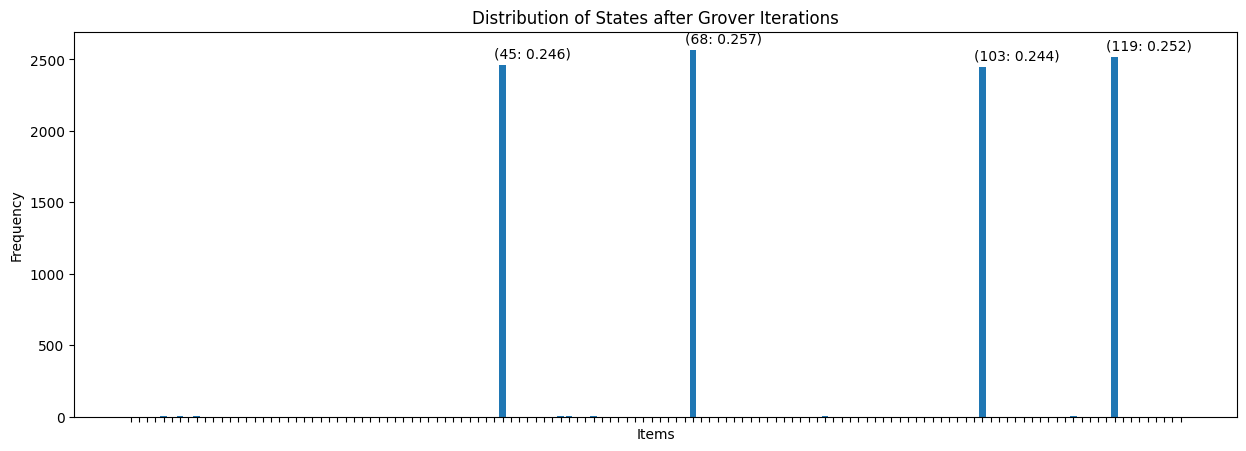

In [181]:
plt.figure(figsize=(15, 5))
x = np.arange(2**qb)
plt.bar(range(2**qb), result_final)

plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Distribution of States after Grover Iterations')

# plt.xticks(x, [f"{i:0{qb}b}" for i in x])
# plt.xticks(x, [f"{i}" for i in x])
plt.xticks(x, [f"" for i in x])
plt.gca().set_xticklabels([])
plt.xticks(visible=False)


xlocs, xlabs = plt.xticks()
for i, s in enumerate(probs):
    if s > 0.1:
        plt.text(xlocs[i]-1, result_final[i] + shots/200, f"({i}: {s:.3f})")
plt.show()